In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
from tqdm.auto import tqdm

import multitask.dataset.tasks as dataset
from multitask.models.individual import get_individual_model
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
sns.set_theme(style='ticks', palette='pastel')
mpl.rcParams['font.family'] = 'Liberation Sans'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
path_data = os.path.join('..', '..', 'data')
path_figure_weights_magnitude = os.path.join('svg', 'figure05a_weights_magnitude.svg')
path_figure_weights_correlation = os.path.join('svg', 'figure05b_weights_correlation.svg')
path_model_individual = os.path.join('..', '..', 'results', 'individual')

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 10 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': None
}

data_folder = check_runs(path_model_individual, parameters)

Found simulation in ../../results/individual with the same parameters (2022-09-28_01_16_35)


In [6]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_individual = pickle.load(handle)

In [7]:
seeds = sorted(list(results_individual.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [8]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

/home/sgalella/miniconda3/envs/multitask/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-ex__3qls/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Plot All RDMs

In [9]:
tasks_datasets

{'parity': Dataset ParityTask
     Number of datapoints: 60000
     Root location: ../../data
     Split: Train,
 'value': Dataset ValueTask
     Number of datapoints: 60000
     Root location: ../../data
     Split: Train}

In [10]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)

biases = np.zeros((num_tasks, num_hidden[0], num_layers))
norm_biases = np.zeros((num_runs, num_tasks, num_layers))
correlations = np.zeros((num_runs, num_layers))

for i_seed, seed in tqdm(enumerate(seeds), total=num_seeds):
    task_activations = []
    task_numbers = []
    indices = results_individual[seed]['indices']

    for i_bias in range(num_layers):
        for i_task, task_name in enumerate(tasks_names):
            state_dict = results_individual[seed][task_name]['model']

            model = get_individual_model(num_hidden,
                                        device)
            model.load_state_dict(state_dict)
            model.to(device)

            biases[i_task, :, i_bias] = model.layers[i_bias].bias.cpu().detach().numpy()
            norm_biases[i_seed, i_task, i_bias] = np.linalg.norm(biases[i_task, :, i_bias], axis=0)

        correlations[i_seed, i_bias] = np.corrcoef(biases[0, :, i_bias],
                                                      biases[1, :, i_bias])[0, 1]
    


 20%|██        | 2/10 [00:00<00:00, 16.08it/s]

Running on GPU.


100%|██████████| 10/10 [00:00<00:00, 17.84it/s]


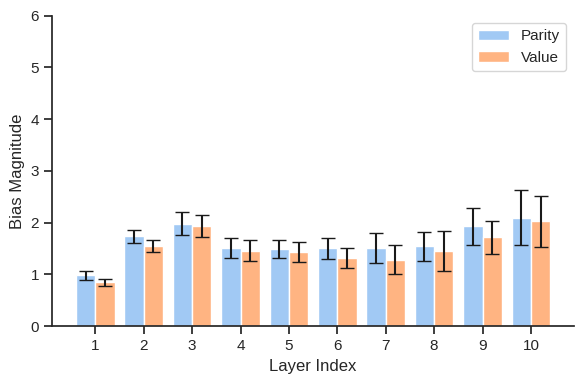

In [11]:
idxs_layers = np.arange(1, 11)

mean_parity = norm_biases.mean(axis=0)[0, :]
mean_value = norm_biases.mean(axis=0)[1, :]
std_parity = norm_biases.std(axis=0)[0, :]
std_value = norm_biases.std(axis=0)[1, :]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.bar(idxs_layers-0.2, mean_parity, width=0.4)
ax.bar(idxs_layers+0.2, mean_value, width=0.4)

ax.errorbar(idxs_layers-0.2, mean_parity, std_parity, color='k', linestyle='', capsize=5)
ax.errorbar(idxs_layers+0.2, mean_value, std_value, color='k', linestyle='', capsize=5)

ax.set_ylim(0, 6)
ax.set_xlabel('Layer Index')
ax.set_ylabel('Bias Magnitude')
ax.set_xticks(idxs_layers)

ax.legend(['Parity', 'Value'])

fig.tight_layout()
fig.savefig(path_figure_weights_magnitude, transparent=True)

plt.show()

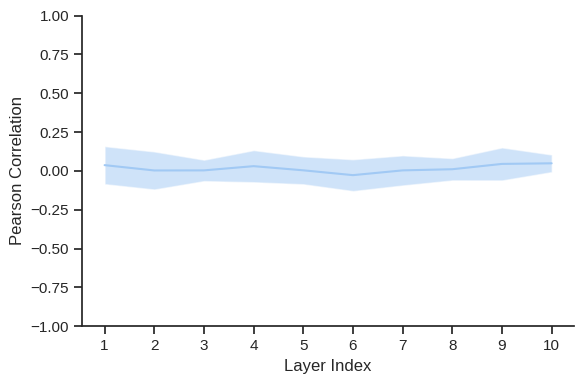

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

mean_corr = correlations.mean(axis=0)
std_corr = correlations.std(axis=0)

ax.plot(idxs_layers, mean_corr)
ax.fill_between(idxs_layers, mean_corr-std_corr, mean_corr+std_corr, alpha=.5)

ax.set_xlabel('Layer Index')
ax.set_ylabel('Pearson Correlation')
ax.set_xticks(idxs_layers)
ax.set_ylim(-1, 1)

fig.tight_layout()
fig.savefig(path_figure_weights_correlation, transparent=True)

plt.show()